## Annealed importance sampling
[This largely follows the review in section 3 of: [Sandwiching the marginal likelihood using bidirectional Monte Carlo (Grosse, Ghahramani, and Adams, 2015)](http://arxiv.org/abs/1511.02543)]
$\newcommand{\x}{\mathbf{x}}
\newcommand{\Z}{\mathcal{Z}}$

**Goal:**

We want to estimate the normalizing constant $\Z = \int p_T(\x) d\x$ of a complicated distribution $p_T$ we know only up to a normalizing constant.

**A basic strategy:**

Importance sampling, i.e. draw each sample from an easy distribution $\x^{(k)} \sim p_1$, then reweight by $w^{(k)}\equiv p_T(\x)/p_1(\x)$. After drawing $K$ such samples, we can estimate the normalizing constant as $$\hat{\Z} = \frac{1}{K} \sum_{k=1}^K w^{(k)} \equiv  \frac{1}{K} \sum_{k=1}^K \frac{p_T(\x^{(k)} )}{p_1(\x^{(k)})}$$.

**Problem:**

Although importance sampling will eventually work as $K \to \infty$ as long as the support of $p_1$ contains the support of $p_T$, this will be extremely inefficient if $p_1$ and $p_T$ are very different.

**Actual strategy:**

Instead of doing the importance reweighting computation in one step, gradually convert a sample from the simpler distribution $p_1$ to the target distribution $p_T$ by introducing a series of intermediate distributions $p_1,p_2,\dots,p_{T}$, chosen so that no $p_t$ and $p_{t+1}$ are dramatically different. We can then estimate the overall importance weight as a product of more reasonable ratios.

**Inputs:**
- Desired number of samples $K$
- An initial distribution $p_1(\x)$ for which we can:
    - Draw samples: $\x_s \sim p_1(\x)$
    - Evaluate the normalizing constant: $\Z_1$
- A target (unnormalized) distribution function: $f_T(\x)$
- A sequence of annealing distribution functions $f_1,\dots,f_T$. These can be almost arbitrary, but here are some options:
    - We can construct these generically by taking **geometric averages** of the initial and target distributions: $f_t(\x_) = f_1(\x)^{1-\beta_t}f_T(\x)^{\beta_t}$
    - In the case of a target distribution $f_T(\x) \propto \exp(-U(\x) \beta)$ (where $\beta$ is the inverse temperature), we could also construct the annealing distributions as Boltzmann distributions at **decreasing temperatures.**
    - In the case of a target distribution defined in terms of a force field, we could also construct the annealing distributions by starting from an **alchemically softened** form of the potential and gradually turning on various parts of the potential.
    - Could use "boost potentials" from accelerated MD (http://www.ks.uiuc.edu/Research/namd/2.9/ug/node63.html)
    - If we have some way to make dimension-matching proposals, we might use **coarse-grained potentials** as intermediates.
- A sequence of Markov transition kernels $\mathcal{T}_1,\dots,\mathcal{T}_T$, where each $\mathcal{T}_t$ leaves its corresponding distribution $p_t$ invariant. These can be almost arbitrary, but here are some options:
    - Random-walk Metropolis
    - Symplectic integrators of Hamiltonian dynamics
    - NCMC

**Outputs:**
- A collection of weights $w^{(k)}$, from which we can compute an unbiased estimate of the normalizing constant of $f_t$ by $\hat{\Z}=\sum_{k=1}^K w^{(k)} / K$

**Algorithm:**

for $k=1$ to $K\\$:
1. $\x_1 \leftarrow$ sample from $p_1(\x)$
2. $w^{(k)} \leftarrow \Z_1$
3. for $t=2$ to $T$:
    - $w^{(k)} \leftarrow w^{(k)} \frac{f_t(\x_{t-1})}{f_{t-1}(\x_{t-1})}$
    - $\x_t \leftarrow $ sample from $\mathcal{T}_t(\x | \x_{t-1})$

### 1. Implement AIS

In [2]:
import numpy as np
import numpy.random as npr
npr.seed(0)
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
%matplotlib inline

def annealed_importance_sampling(draw_exact_initial_sample,
                                 transition_kernels,
                                 annealing_distributions,
                                 n_samples=1000):
    '''
    draw_exact_initial_sample:
        Signature:
            Arguments: none
            Returns: R^d
    
    transition_kernels:
        length-T list of functions, each function signature:
            Arguments: R^d
            Returns: R^d
        
        can be any transition operator that preserves its corresponding annealing distribution
        
    annealing_distributions:
        length-T list of functions, each function signature:
            Arguments: R^d
            Returns: R^+
        
        annealing_distributions[0] is the initial density
        annealing_distributions[-1] is the target density
 
    n_samples:
        positive integer
    
    '''
    
    dim=len(draw_exact_initial_sample())
    T = len(annealing_distributions)
    weights = np.ones(n_samples,dtype=np.double)
    ratios = []
    
    xs = []
    for k in range(n_samples):
        x = np.zeros((T,dim))
        ratios_ = np.zeros(T-1,dtype=np.double)
        x[0] = draw_exact_initial_sample()
        
        for t in range(1,T):
            
            
            f_tminus1 = annealing_distributions[t-1](x[t-1])
            f_t = annealing_distributions[t](x[t-1])
            
            ratios_[t-1] = f_t/f_tminus1
            weights[k] *= ratios_[t-1]
            
            x[t] = transition_kernels[t](x[t-1],target_f=annealing_distributions[t])

        xs.append(x)
        ratios.append(ratios_)
    
    return np.array(xs), weights, np.array(ratios)

### 2. Define annealing distributions

Here we'll be annealing between two unnormalized Gaussian distributions with geometric mean intermediates.

They have the same variances, so they should have the same normalizing constants.

In [3]:
num_intermediates = 25
betas = np.linspace(0,1,num_intermediates+2)
dim=1

def initial_density(x):
    return np.exp(-((x)**2).sum()/2)

def draw_from_initial():
    return npr.randn(dim)

def target_density(x):
    return np.exp(-((x-4)**2).sum()/2)
    
class GeometricMean():
    def __init__(self,initial,target,beta):
        self.initial = initial
        self.target = target
        self.beta = beta
    
    def __call__(self,x):
        f1_x = self.initial(x)
        fT_x = self.target(x)
        return f1_x**(1-self.beta) * fT_x**self.beta

annealing_distributions = [GeometricMean(initial_density,target_density,beta) for beta in betas]

### 2.1. Plot annealing distributions

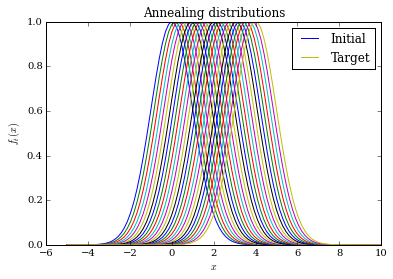

In [7]:
x = np.linspace(-5,10,100)
for i,f in enumerate(annealing_distributions):
    if i == 0 or i == len(annealing_distributions)-1:
        if i == 0:
            label='Initial'
        else:
            label='Target'
    else:
        label=None
    y = np.array([f(x_) for x_ in x])
    
    plt.plot(x,y/y.max(),label=label)
    
plt.title('Annealing distributions')
plt.xlabel(r'$x$')
plt.ylabel(r'$f_t(x)$')
plt.legend(loc='best')

### 3. Define transition kernel
Here we'll just do a metropolized random walk with spherical gaussian proposals.

In [8]:
def gaussian_random_walk(x,
                      target_f,
                      n_steps=10,
                      scale=0.5):
    
    x_old = x
    f_old = target_f(x_old)
    dim=len(x)
    
    for i in range(n_steps):
    
        proposal = x_old + npr.randn(dim)*scale
        f_prop = target_f(proposal)
        
        if (f_prop / f_old) > npr.rand():
            x_old = proposal
            f_old = f_prop
    
    return x_old

In [9]:
transition_kernels = [gaussian_random_walk]*len(annealing_distributions)

### 4. Run AIS on this toy example

In [10]:
xs, weights, ratios = annealed_importance_sampling(draw_from_initial,
                                 transition_kernels,
                                 annealing_distributions,
                                 n_samples=10000)

#### 4.1. Plot results

It should converge to one, since the initial and target distributions have the same normalizing constant.

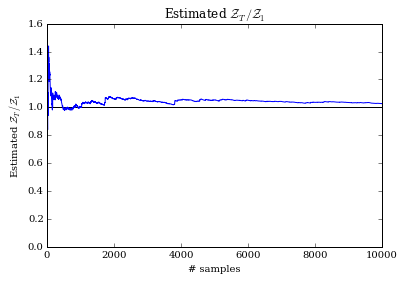

In [12]:
plt.plot((np.cumsum(weights)/np.arange(1,len(weights)+1)))
plt.hlines(1.0,0,len(weights))
plt.xlabel('# samples')
plt.ylabel(r'Estimated $\mathcal{Z}_T / \mathcal{Z}_1$')
plt.title(r'Estimated $\mathcal{Z}_T / \mathcal{Z}_1$')

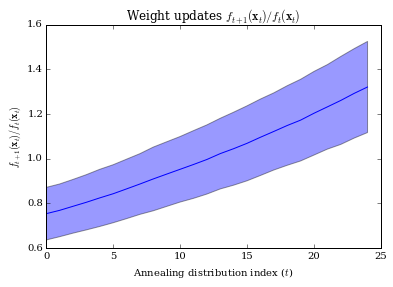

In [15]:
ratios_ = ratios

mean=ratios_.mean(0)[1:]
err = ratios_.std(0)[1:]


plt.plot(mean);
plt.fill_between(range(len(mean)),mean-err,mean+err,alpha=0.4);
plt.xlabel(r'Annealing distribution index ($t$)')
plt.ylabel(r'$f_{t+1}(\mathbf{x}_{t})/f_{t}(\mathbf{x}_{t})$')
plt.title(r'Weight updates $f_{t+1}(\mathbf{x}_{t})/f_{t}(\mathbf{x}_{t})$')

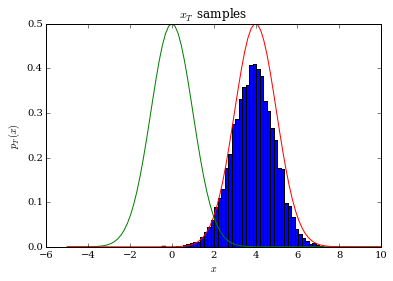

In [16]:
end_samples = np.array([x_[-1] for x_ in xs])
plt.hist(end_samples,bins=50,normed=True);
plt.plot(x,[initial_density(x_)/2 for x_ in x])
plt.plot(x,[target_density(x_)/2 for x_ in x])
plt.title(r"$x_T$ samples")
plt.xlabel(r'$x$')
plt.ylabel(r'$p_T(x)$')

### 5. A more interesting example

Let's sample a biomolecule's configuration space in this way, and maybe estimate its partition function.

For now, let's do alanine dipeptide.

### 5.1-5.2. Define annealing distributions and transition kernels

In [17]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from openmmtools.integrators import MetropolisMonteCarloIntegrator,HMCIntegrator

# all I want is the alanine dipeptide topology
from msmbuilder.example_datasets import AlanineDipeptide
ala = AlanineDipeptide().get().trajectories

top_md = ala[0][0].topology
topology = top_md.to_openmm()
n_atoms = top_md.n_atoms
dim = n_atoms*3

# create an openmm system
forcefield = ForceField('amber99sb.xml','amber10_obc.xml')
system = forcefield.createSystem(topology,
    nonbondedCutoff=1*nanometer, constraints=HBonds)
integrator = HMCIntegrator(300*kelvin)
simulation = Simulation(topology, system, integrator)

# create a thin wrapper class
class PeptideSystem():
    def __init__(self):
        self.simulation = simulation
        self.positions = self.simulation.context.getState(getPositions=True).getPositions().value_in_unit(nanometer)
        self.n_atoms = len(self.positions)
    
    def evaluate_potential_flat(self,position_vec):
        positions = position_vec.reshape(self.n_atoms,3)
        self.simulation.context.setPositions(positions)
        return self.simulation.context.getState(getEnergy=True).getPotentialEnergy()
    
    def propagate(self,position_vec,n_steps=1000,temp=300):
        integrator = HMCIntegrator(temp*kelvin)
        self.simulation = Simulation(topology,system,integrator)
        positions = position_vec.reshape(self.n_atoms,3)
        self.simulation.context.setPositions(positions)
        simulation.step(n_steps)
        
        return np.array(self.simulation.context.getState(getPositions=True).getPositions().value_in_unit(nanometer)).flatten()
    
    def probability_at_temp(self,position_vec,temp=300.0):
        return np.exp(-self.evaluate_potential_flat(position_vec).value_in_unit(kilojoule/mole)/temp)
    

peptide = PeptideSystem()
temperatures = np.logspace(3,0,1000)*300

# for some reason I can't create a bunch of parametrized anonymous functions in a list comprehension?
# i.e. [lambda x:peptide.probability_at_temp(x,t) for t in temperatures] gives me a list of functions
# that all evaluate probability at t = temperatures[-1]...
# just creating a seperate object for each temperature to avoid any surprises here
class TempDist():
    def __init__(self,temperature):
        self.temp = temperature
    
    def __call__(self,x):
        return peptide.probability_at_temp(x,self.temp)

annealing_distributions = [initial_density] + [TempDist(t) for t in temperatures]

#num_intermediates = 1000
#betas = np.linspace(0,1,num_intermediates+2)
#annealing_distributions = [GeometricMean(initial_density,TempDist(300),beta) for beta in betas]

# same deal for transition kernels at different temperatures
class TempProp():
    def __init__(self,temperature):
        self.temp = temperature
    
    def __call__(self,x,target_f=None):
        return peptide.propagate(x,n_steps=100,temp=self.temp)

#transition_kernels = [None] + [TempProp(t) for t in temperatures] # transition_kernels[0] is never referenced...

scales = np.logspace(1,0,len(annealing_distributions)+1)*0.005
class RwProp():
    def __init__(self,n_steps=100,scale=0.05):
        self.n_steps=n_steps
        self.scale=scale
    
    def __call__(self,x,target_f):
        return gaussian_random_walk(x,target_f,n_steps=self.n_steps,scale=self.scale)
        
transition_kernels = [RwProp(n_steps=30,scale=s) for s in scales]

In [18]:
%%timeit
peptide.evaluate_potential_flat(npr.randn(dim))

The slowest run took 693.52 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 1.29 ms per loop


In [20]:
%%timeit
transition_kernels[1](npr.randn(dim),annealing_distributions[1])

10 loops, best of 3: 33 ms per loop


In [21]:
len(annealing_distributions),len(transition_kernels)

(1001, 1002)

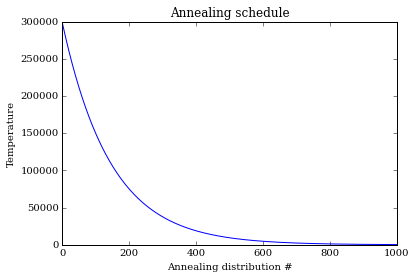

In [22]:
# annealing schedule
plt.plot(temperatures)
plt.xlabel('Annealing distribution #')
plt.ylabel('Temperature')
plt.title('Annealing schedule')

### 5.3. Run AIS
From $\mathcal{N}(\mathbf{0},\mathbf{I})$ to $\exp[-U(\x)/k_BT]$ in only a gazillion annealing distributions!

In [23]:
%%time
xs, weights, ratios = annealed_importance_sampling(draw_from_initial,
                                 transition_kernels,
                                 annealing_distributions,
                                 n_samples=1)

CPU times: user 13.3 s, sys: 14.1 s, total: 27.4 s
Wall time: 36.3 s


In [24]:
weights,np.log(weights)

(array([  4.36400582e-38]), array([-86.02484313]))

In [25]:
# expected number of hours to collect 1000 samples:
(1000*36/60)/60

10

In [26]:
%%time
xs, weights, ratios = annealed_importance_sampling(draw_from_initial,
                                 transition_kernels,
                                 annealing_distributions,
                                 n_samples=1000)

CPU times: user 3h 31min 21s, sys: 3h 56min 36s, total: 7h 27min 57s
Wall time: 8h 55min 39s


/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: RuntimeWarning: divide by zero encountered in double_scalars


In [27]:
best_traj = weights.argmax()

In [28]:
coords = [xs[best_traj][i].reshape(n_atoms,3) for i in range(len(xs[0]))]

In [29]:
import mdtraj as md
annealing_traj = md.Trajectory(coords,top_md)
annealing_traj.save_pdb('annealing_traj.pdb')

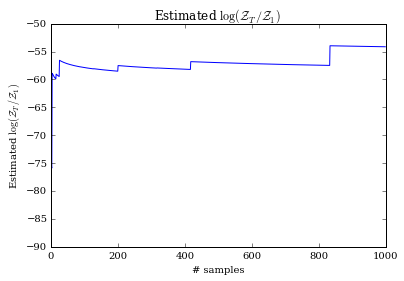

In [30]:
plt.plot(np.log((np.cumsum(weights)/np.arange(1,len(weights)+1))))
plt.xlabel('# samples')
plt.ylabel(r'Estimated $\log ( \mathcal{Z}_T / \mathcal{Z}_1 )$')
plt.title(r'Estimated $\log ( \mathcal{Z}_T / \mathcal{Z}_1 )$')

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


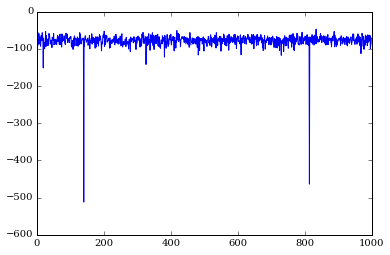

In [31]:
plt.plot(np.log(weights))

In [32]:
ratios.mean(0)[:10]

array([  3.98294967e+09,   8.42721967e-01,   8.57608872e-01,
         8.69818556e-01,   8.79368354e-01,   8.87543742e-01,
         8.93800080e-01,   8.98311391e-01,   9.03096689e-01,
         9.06680996e-01])

In [46]:

ratios_ = ratios

mean=ratios_.mean(0)[1:]
err = ratios_.std(0)[1:]


plt.plot(mean);
plt.fill_between(range(len(mean)),mean-err,mean+err,alpha=0.4);
plt.xlabel(r'Annealing distribution index ($t$)')
plt.ylabel(r'$f_t/f_{t-1}$')
plt.title('Weight updates')
plt.savefig('weight_updates.jpg',dpi=300)
plt.close()

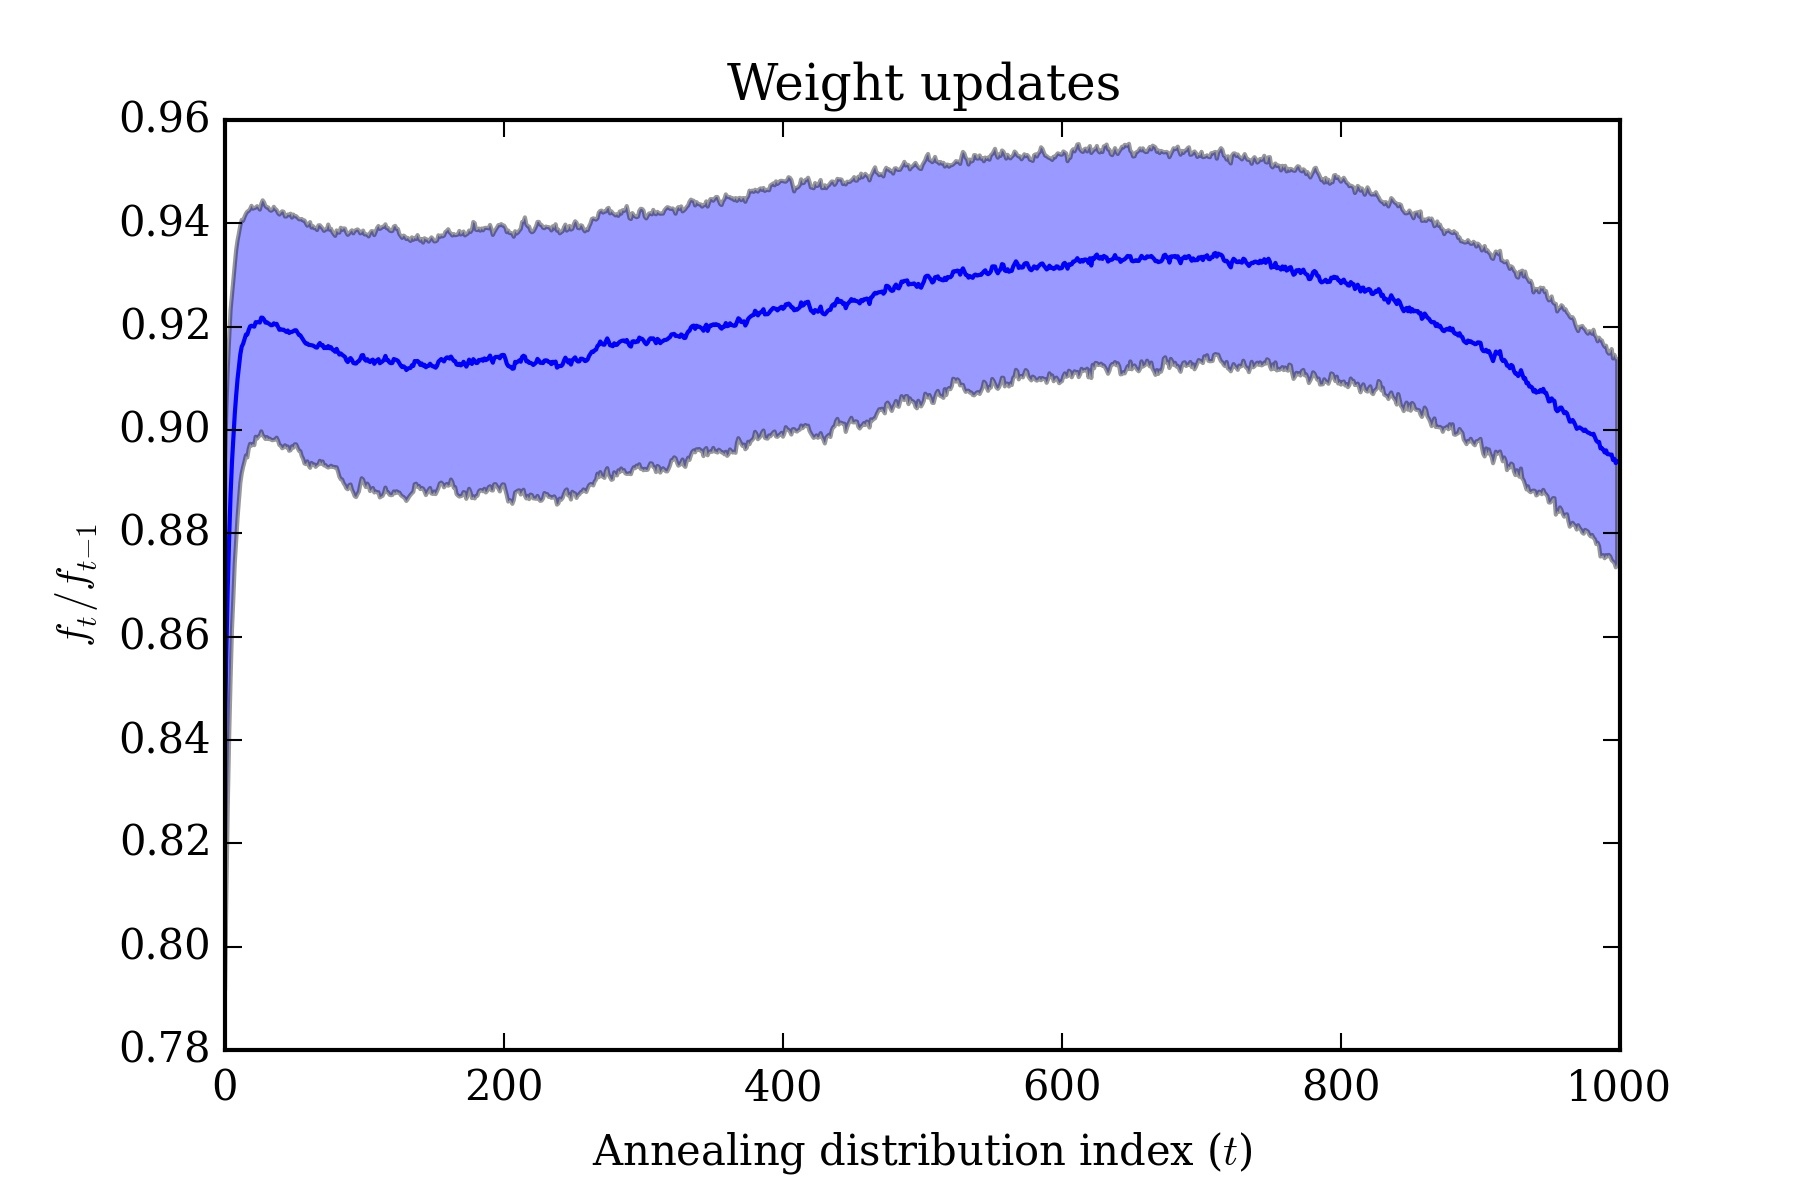

In [47]:
from IPython.display import Image
Image('weight_updates.jpg',retina=True)

In [48]:
# numerical underflow isn't as big a concern as I thought
np.exp(sum(np.log(ratios[0]))),weights[0]

(1.4541171094051844e-39, 1.4541171094051813e-39)

In [49]:
np.savez('AIS_results_alanine_dipeptide.npz',ratios)

In [ ]:
# what if, instead of running 30 steps of rw metropolis between each of a 1000 annealing distributions, we instead
# run 1 step of rw metropolis between each of 30,000 annealing distributions?